## Intro to Data Analysis using Pandas DataFrames

### Titanic Passengers Dataset

In [ ]:
%pylab inline
import seaborn as sns
import pandas as pd

path = '/class/itpmssd/datasets/titanic.csv'
titanic = pd.read_csv(path)

In [ ]:
titanic.head()

In [ ]:
titanic.describe()

In [ ]:
titanic.Age.hist(bins=25, figsize=(10,6))
xlabel('age')
ylabel('number of passengers')

In [ ]:
# Now let's group by Sex, and then see the differences in age
grouped = titanic.groupby('Sex')
grouped.Age.median()

In [ ]:
grouped.Age.describe()

In [ ]:
grouped.get_group('male').Age.hist(bins=20, figsize=(12,6), label="male")
grouped.get_group('female').Age.hist(bins=20, label="female")
legend()
title("distribution of passengers by age/sex")
xlabel("age")

In [ ]:
sns.boxplot(grouped.Age.get_group('male'), linewidth=2)
figsize(10,4)
sns.set_style("whitegrid")

In [ ]:
sns.boxplot(grouped.Age.get_group('female'), linewidth=2)

In [ ]:
# Age: distribution plot - histogram + kde

sns.distplot(titanic.Age.dropna())

In [ ]:
corr_titanic = titanic.corr()
corr_titanic

In [ ]:
# Set up the matplotlib figure size
plt.subplots(figsize=(12, 9))
sns.corrplot(titanic)

## From CSV File: Stop and Frisk / NYPD

In [ ]:
# Let's grab the csv file ('wget'), unzip it, and change its name to something that doesn't include spaces.
# SSH into your remote machine and run the following commands:

''' 
    cd /class/itmpssd/datasets
    wget http://www.nyclu.org/files/stopandfrisk/Stop-and-Frisk-2012.zip
    unzip Stop-and-Frisk-2012.zip
    mv SQF\ 2012.csv sf2012.csv
'''

#### Now let's explore the dataset using the command line first

In [1]:
# Now we can open the file
import seaborn as sns
import pandas as pd

path = '/class/itpmssd/datasets/sf2012_sm.csv'
df = pd.read_csv(path, low_memory=False)

In [ ]:
# different ways to look at the data (since it is way too large to simply print)

df.head()

In [ ]:
df.tail(4)

In [ ]:
df[900:905]

### Cleaning the Data

In [2]:
import datetime

# translate the messy date string into something cleaner -> a datetime structure
# (M)MDDYYYY

def parse_hour(timestop):
    minute = timestop % 100
    hour = timestop / 100
    return hour,minute

def parse_date(datestop):
    month = int(str(datestop)[:-6])
    day = int(str(datestop)[-6:-4])
    year = int(str(datestop)[-4:])
    return year, month, day

def make_datetime(datestop, timestop):
    year, month, day = parse_date(datestop)
    hour, minute = parse_hour(timestop)
    return datetime.datetime(year, month, day, hour)

def make_date(datestop):
    year, month, day = parse_date(datestop)
    return datetime.datetime(year, month, day)

In [63]:
print parse_date(df.ix[0].datestop)
print parse_hour(df.ix[0].timestop)
print make_datetime(df.ix[0].datestop, df.ix[0].timestop)
print make_date(df.ix[0].datestop)

(2012, 1, 1)
(1, 15)
2012-01-01 01:00:00
2012-01-01 00:00:00


In [3]:
# now lets add a parsed datetime row in our data frame - by applying the function that we've just built
# this will give us a 'dt' field we can use to group by

df['dt']=df[['datestop','timestop']].apply(lambda x: make_datetime(x['datestop'], x['timestop']), axis=1)
df['d']=df[['datestop']].apply(lambda x: make_date(x['datestop']), axis=1)

In [74]:
df.tail()

,year,pct,ser_num,datestop,timestop,city,sex,race,dob,age,...,offverb,officrid,offshld,ac_rept,ac_inves,radio,recstat,linecm,dt,d
99994,2012,75,5073,2142012,1510,2,1,1,2131992,19,...,0,0,0,0,0,0,A,1,2012-02-14 15:00:00,2012-02-14
99995,2012,75,5074,2142012,1510,2,1,1,4161996,15,...,0,0,0,0,0,0,A,1,2012-02-14 15:00:00,2012-02-14
99996,2012,75,5075,2142012,1510,2,1,1,6091992,19,...,0,0,0,0,0,0,A,1,2012-02-14 15:00:00,2012-02-14
99997,2012,20,524,2142012,1510,1,1,1,12311900,24,...,0,0,0,0,0,0,A,1,2012-02-14 15:00:00,2012-02-14
99998,2012,84,653,2142012,1510,2,1,2,7191996,14,...,0,0,0,0,0,0,A,1,2012-02-14 15:00:00,2012-02-14


### Grouping: split-apply-combine

In [5]:
# Grouping - counting the number of reported incidents per hour (can also do grouped.count())

df.groupby(df.dt).size()[:10]

dt
2012-01-01 00:00:00    126
2012-01-01 01:00:00    197
2012-01-01 02:00:00    122
2012-01-01 03:00:00     86
2012-01-01 04:00:00     83
2012-01-01 05:00:00     40
2012-01-01 06:00:00     16
2012-01-01 07:00:00     10
2012-01-01 08:00:00     10
2012-01-01 09:00:00      9
dtype: int64

In [ ]:
# let's make a plot - that shows trends over time
%pylab inline

df.groupby(df.dt).size().plot(figsize=(20,6))

In [ ]:
# we can easily specify a smaller date range
df.groupby(df.dt).size()[:'2012-02-16'].plot(figsize=(20,6))

### Let's examine age

In [ ]:
# apparently immortality is imminent
sns.boxplot(df.age)

In [ ]:
# DRAAAAATS - more weirdnesses in the data!

In [ ]:
# argmax prints the row # for the maximum value in a given column
print 'maximum age index number:',df.age.argmax(),'\n'

# ix[] -> is a way to access values given a specific row
print 'maximum age row:',df.ix[1021]

In [ ]:
# How bad is it? How many rows in our data have weird age figures?

print 'number of problematic rows:',len(df[[a>100 for a in df.age]])

# 0.2% of our data is problematic
len(df[[a>100 for a in df.age]])/float(len(df))


In [4]:
# filter out rows with faulty age info
df = df[[x<100 for x in df.age]]

In [ ]:
# Let's try this again
sns.boxplot(df.age)

### Filter out Columns

In [4]:
# we can always get rid of unnecessary columns - makes DataFrames easier to handle

wanted_columns = ['dt','d','age','sex','race','height','weight','build','frisked']

sm_df = df[wanted_columns]
sm_df.head()

,dt,d,age,sex,race,height,weight,build,frisked
0,2012-01-01 01:00:00,2012-01-01,20,1,1,69,155,4,1
1,2012-01-01 03:00:00,2012-01-01,18,1,3,67,175,3,0
2,2012-01-01 20:00:00,2012-01-01,19,1,1,69,180,3,0
3,2012-01-02 12:00:00,2012-01-02,37,1,1,65,210,1,0
4,2012-01-04 22:00:00,2012-01-04,21,1,3,67,170,3,0


### Now let's take a look at Race

In [ ]:
race_labels = {
    1:'black', 
    2:'black_Hispanic', 
    3:'white_Hispanic', 
    4:'white', 
    5:'Asian_Pacific_Islander', 
    6:'Am_Indian_Native_Alaskan'
}

In [ ]:
sm_df.race[10:20]

In [ ]:
# we can use our handy dictionary to apply the labels
[race_labels[x] for x in sm_df.race[10:20]]

In [46]:
# Handy way to count values in a column

sm_df.race.value_counts()

1    52768
3    25117
4     8813
2     6993
5     3069
6      420
dtype: int64

In [ ]:
# histogram: show entries by race
sm_df.race.hist(figsize=(12,6))
ylabel('number of incidents')
xlabel('race')
title('incidents by race')

In [5]:
grouped = sm_df.groupby('race')
black = grouped.get_group(1)
white_hispanic = grouped.get_group(3)
white = grouped.get_group(4)

In [7]:
black.describe()

,age,sex,race,height,weight,build,frisked
count,52768.000000,52491.000000,52768,52768.000000,52768.000000,52181.000000,52768.000000
mean,28.100819,0.929836,1,69.062045,171.109479,3.163661,0.568147
std,12.398641,0.255426,0,3.196773,42.920988,0.799726,0.495339
min,0.000000,0.000000,1,36.000000,0.000000,1.000000,0.000000
25%,19.000000,1.000000,1,67.000000,150.000000,3.000000,0.000000
50%,24.000000,1.000000,1,69.000000,170.000000,3.000000,1.000000
75%,35.000000,1.000000,1,71.000000,185.000000,4.000000,1.000000
max,99.000000,1.000000,1,95.000000,999.000000,4.000000,1.000000


Populating the interactive namespace from numpy and matplotlib


array([[<matplotlib.axes.AxesSubplot object at 0x7faa365b3310>,
        <matplotlib.axes.AxesSubplot object at 0x7faa3608ea50>]], dtype=object)

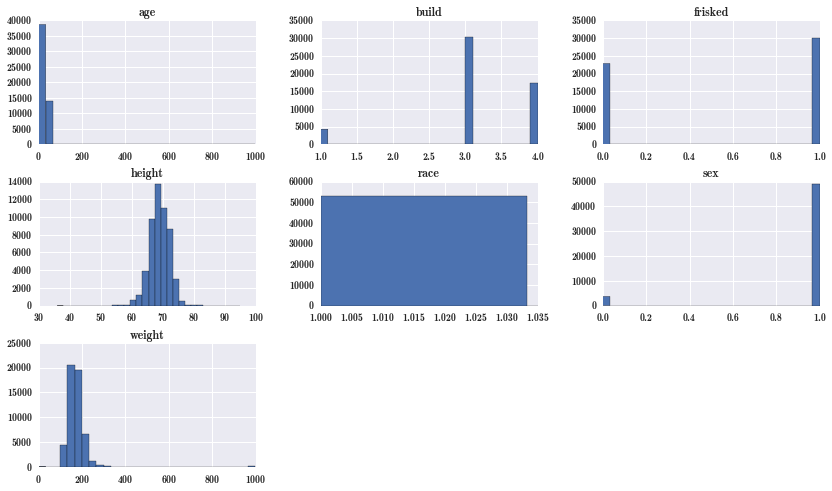

In [7]:
%pylab inline
grouped.get_group(1).hist(bins=30,figsize=(14,8))

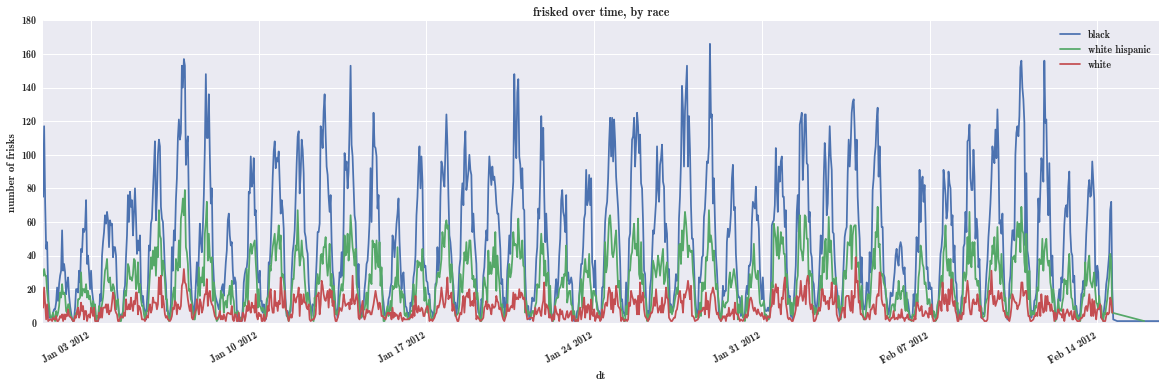

In [51]:
# plot frisks broken down by race over time
black.groupby('dt').frisked.size()[:'2012-02-16'].plot(figsize=(20,6), label='black')
white_hispanic.groupby('dt').frisked.size()[:'2012-02-16'].plot(figsize=(20,6), label='white hispanic')
white.groupby('dt').frisked.size()[:'2012-02-16'].plot(figsize=(20,6), label='white')
legend()
title('frisked over time, by race')
ylabel('number of frisks')

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


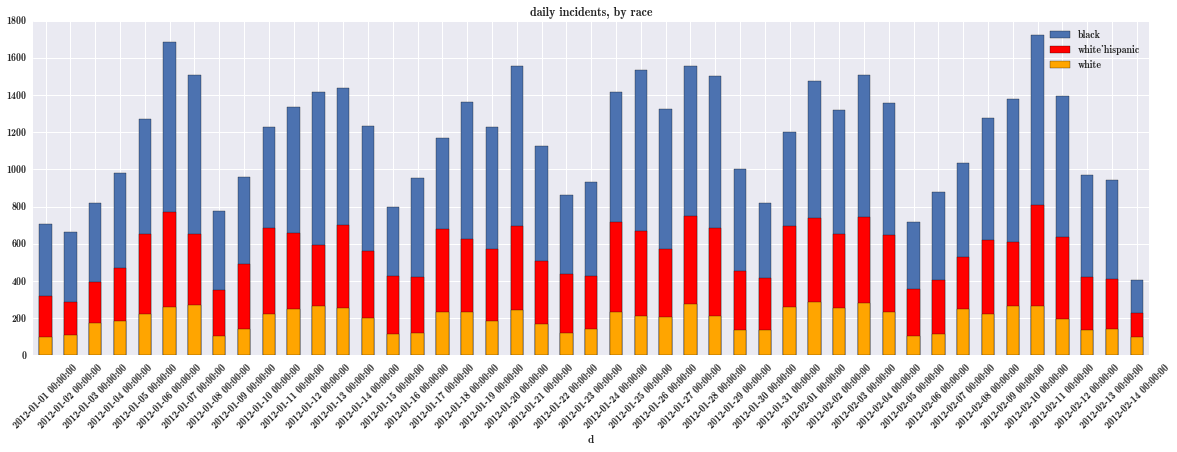

In [8]:
black.groupby('d').size()[:'2012-02-16'].plot(kind="bar", figsize=(20,6), label='black')
white_hispanic.groupby('d').size()[:'2012-02-16'].plot(kind="bar", color='red', figsize=(20,6), label='white_hispanic')
white.groupby('d').size()[:'2012-02-16'].plot(kind="bar", color='orange', figsize=(20,6), label='white')
xticks(rotation=45)
legend()
title('daily incidents, by race')

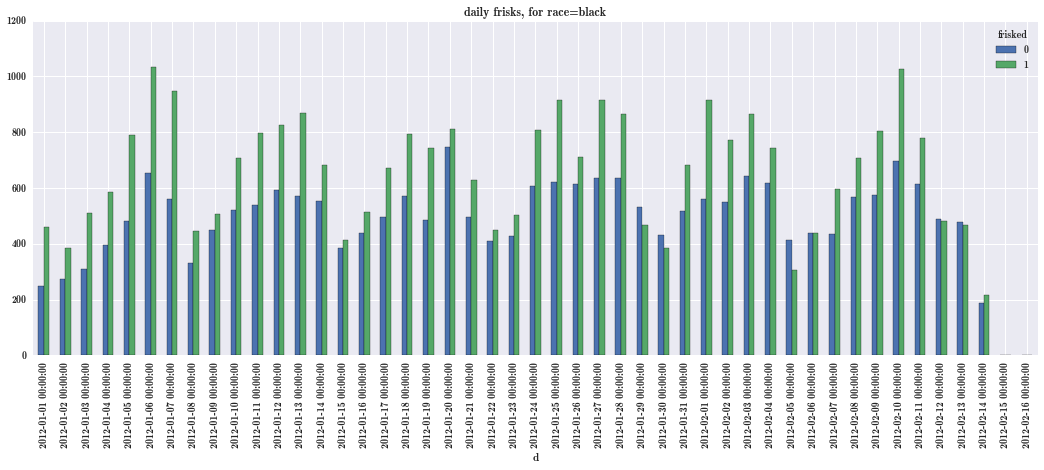

In [23]:
black.groupby(['d','frisked']).size()[:'2012-02-16'].unstack('frisked').plot(kind="bar", figsize=(18,6))
title('daily frisks, for race=black')

### Correlation

In [54]:
sm_df.corr()

,age,sex,race,height,weight,build,frisked
age,1.000000,0.001188,0.016392,0.073676,0.206114,-0.159466,-0.149275
sex,0.001188,1.000000,-0.019606,0.299459,0.158251,-0.006539,0.147609
race,0.016392,-0.019606,1.000000,-0.143102,-0.044890,0.003513,-0.060570
height,0.073676,0.299459,-0.143102,1.000000,0.360286,-0.129347,0.061372
weight,0.206114,0.158251,-0.044890,0.360286,1.000000,-0.426790,0.000555
build,-0.159466,-0.006539,0.003513,-0.129347,-0.426790,1.000000,0.017623
frisked,-0.149275,0.147609,-0.060570,0.061372,0.000555,0.017623,1.000000


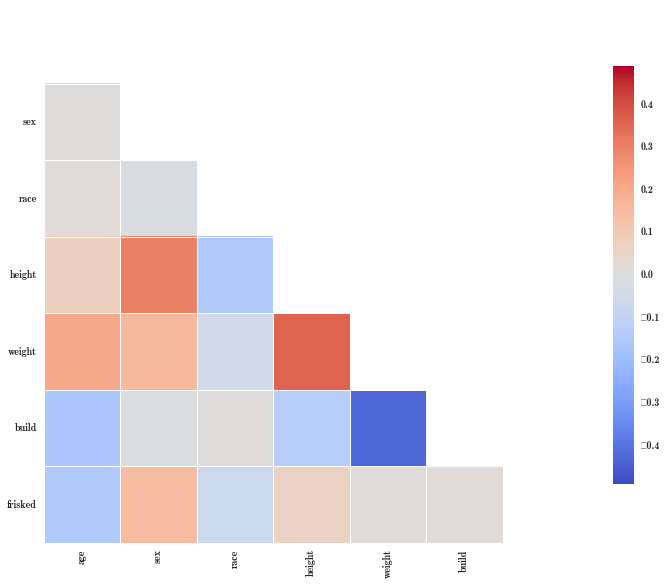

In [69]:
plt.subplots(figsize=(12, 10))
sns.corrplot(sm_df, annot=False, diag_names=False)

### Pickle the small DataFrame (for when our system crashes)

In [19]:
# save the data for later
import pickle

f = open('/class/itpmssd/Week_2/sm_df.p','wb')
pickle.dump(sm_df,f)
f.close()

In [23]:
# load the data from pickled file

pkl_file = open('/class/itpmssd/Week_2/sm_df.p','rb')
sm_df = pickle.load(pkl_file)

# ... aaand VOILA!

### Create Smaller Stop-and-Frisk File/DataFrame

In [ ]:
# Create Smaller File -> so that we can look at longer term trends
import csv
import pandas as pd

columns = ['datestop','timestop','sex','race','age','height','weight','build','frisked']
wanted_indices = set([3,4,6,7,9,10,11,14,16])

columns = {
    3:'datestop',
    4:'timestop',
    6:'sex',
    7:'race',
    9:'age',
    10:'height',
    11:'weight',
    14:'build',
    16:'frisked'
}

small_dict = {c:[] for c in columns.values()}

cnt = 0
with open("/class/itpmssd/datasets/sf2012.csv",'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if cnt==0:
            # dismiss the first row of the CSV file -> column headers
            cnt += 1
            continue
        
        # parse the date from the given string
        cur_date = calc_datetime(row[3])
        
        for k,c in columns.items():
            if c=='datestop':
                small_dict[c].append(cur_date)
            else:
                if row[k]!='':
                    # add relevant value to the dictionary
                    small_dict[c].append(int(row[k]))
                else:
                    # add zeros where there's no data -> generally messes up our distribution estimation
                    small_dict[c].append(0)
        
        cnt += 1

In [ ]:
sm_df = pd.DataFrame.from_dict(small_dict)
sm_df.head()

### Kernel Density Estimators

In [ ]:
# Kernel Density Estimate Plot -> KDE is a way to estimate the probability density function
# default kernel is Gaussian

sns.kdeplot(titanic.Age.dropna(), shade=True)

In [ ]:
pal = sns.blend_palette([sns.desaturate("royalblue", 0), "royalblue"], 5)
bws = [.1, .25, .5, 1, 2]

# bw = bandwidth
# lw = line width
for bw, c in zip(bws, pal):
    sns.kdeplot(titanic.Age.dropna(), bw=bw, color=c, lw=1.8, label=bw)

plt.legend(title="kernel bandwidth")
sns.rugplot(titanic.Age.dropna(), color="#333333");

In [ ]:
sns.kdeplot(grouped.get_group('male').Age.dropna(),label='male')
sns.kdeplot(grouped.get_group('female').Age.dropna(),label='female')

In [ ]:
# Violin Plot - effectively a box plot with a rotated kernel density plot on each side
# in addition to showing what box plots show, they also present the probability density of the data at different values

sns.violinplot(titanic.Age.dropna())

In [ ]:
sns.violinplot(titanic.Age.dropna(), titanic.Sex)

### Related Reads and References

- Precinct or Prejudice? understanding racial disparities in New York City's stop-and-frisk policy: https://5harad.com/papers/frisky.pdf

- Kaggle competition (Titanic Dataset)
http://nbviewer.ipython.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb

- Seaborn Plotting Library (w/some great examples)
http://stanford.edu/~mwaskom/software/seaborn/
